**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
from datetime import datetime, timedelta
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json
import corner

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
from covid19model.optimization.run_optimization import full_calibration_wave1, full_calibration_wave2
from covid19model.models.utils import draw_sample_COVID19_SEIRD


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# import dask

# from dask.distributed import Client, progress
# client = Client(threads_per_worker=16, n_workers=1)
# client

# Get public data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)


In [4]:
raw_hosp_data = pd.read_csv('../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
Luik_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Liège']

In [5]:
#Luik_hosp_data.plot('DATE','NEW_IN')

In [6]:
Luik_ts = Luik_hosp_data[['DATE','NEW_IN']].set_index('DATE')

<IPython.core.display.Javascript object>


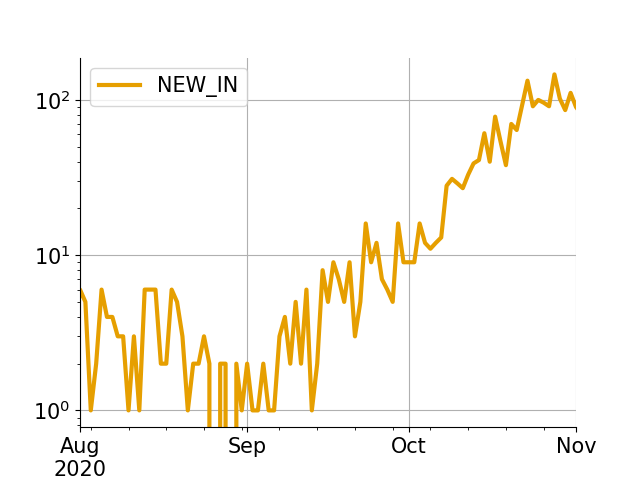

(18475.0, 18567.0)

In [7]:
fig,ax = plt.subplots()
Luik_ts.reset_index() .plot('DATE','NEW_IN', logy=True, ax=ax)
ax.set_xlim('2020-08-01', '2020-11-01')

# Load data

In [8]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size
#province_names = pd.read_csv('../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../data/interim/demographic/initN_province.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[60000].iloc[:9]))

In [9]:
fig_path = '../results/calibrations_provinces/'
samples_path = '../data/interim/model_parameters/provinces/'

In [10]:
def draw_sample_beta_COVID19_SEIRD(parameter_dictionary,samples_dict):
    """
    A function to draw parameter samples obtained with MCMC during model calibration and assign them to the parameter dictionary of the model.
    Tailor-made for the BIOMATH COVID-19 SEIRD model.

    Parameters
    ----------
    model : object
        BIOMATH model object
    
    samples_dict : dictionary
        Dictionary containing the samples of the sampled parameters: beta, l and tau.

    Returns
    ----------
    model : object
        BIOMATH model object

    """
    # Use posterior samples of fitted parameters
    parameter_dictionary['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    return parameter_dictionary

# Initialize the model

In [11]:
def ramp_fun(Nc_old, Nc_new, t, tau_days, l, t_start):
    """
    t : current date
    tau : number of days before measures start having an effect
    l : number of additional days after the time delay until full compliance is reached
    """
    return Nc_old + (Nc_new-Nc_old)/l * (t-t_start-tau_days)/pd.Timedelta('1D')

In [12]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy1,policy2,l,tau,prevention, start_date, policy_time):
    tau_days = pd.to_timedelta(tau, unit='D')
    l_days = pd.to_timedelta(l, unit='D')
    if t <= start_date + tau_days:
        return policy1
    elif start_date + tau_days < t <= start_date + tau_days + l_days:
        return ramp_fun(policy1, policy2, t, tau_days, l, start_date)
    else:
        return prevention*policy2

In [13]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 500,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

In [14]:
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave1_test'


# Calibration on first wave

In [15]:
## First wave
start_date = '2020-03-15'
end_beta = '2020-03-25'#'2020-03-22'
end_ramp = '2020-05-23'

In [16]:
len(Luik_ts.loc[start_date:end_beta])

11

In [17]:
len(Luik_ts.loc[end_beta:end_ramp])

60

In [18]:
# function parameters 
# maxiter=100
# popsize=200
# steps_mcmc=10000


In [21]:
samples_dict = full_calibration_wave1(model, timeseries, spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=5, popsize=5, steps_mcmc=100, discard=0)

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
New best for swarm at iteration 1: [1.05168450e+01 5.62765058e+01 2.76250711e-02] 30.36723552807721
Best after iteration 1: [1.05168450e+01 5.62765058e+01 2.76250711e-02] 30.36723552807721
Best after iteration 2: [1.05168450e+01 5.62765058e+01 2.76250711e-02] 30.36723552807721
Best after iteration 3: [1.05168450e+01 5.62765058e+01 2.76250711e-02] 30.36723552807721
Best after iteration 4: [1.05168450e+01 5.62765058e+01 2.76250711e-02] 30.36723552807721
Best after iteration 5: [1.05168450e+01 5.62765058e+01 2.76250711e-02] 30.36723552807721
Stopping search: maximum iterations reached --> 5

2) Markov-Chain Monte-Carlo sampling



100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Use this estimate with caution and run a longer chain!
---------------------------------------------------------------------------------------------------------

CALIBRATING COMPLIANCE RAMP
---------------------------

1) Particle swarm optimization


2) Markov-Chain Monte-Carlo sampling

No constraints given.
New best for swarm at iteration 1: [28.17312762  9.65098923  1.39139352  0.        ] 278.74191933439647
Best after iteration 1: [28.17312762  9.65098923  1.39139352  0.        ] 278.74191933439647
Best after iteration 2: [28.17312762  9.65098923  1.39139352  0.        ] 278.74191933439647
New best for swarm at iteration 3: [33.17276263 10.70993615  0.          0.        ] 277.60511869035207
Best after iteration 3: [33.17276263 10.70993615  0.          0.        ] 277.60511869035207


  0%|          | 0/100 [00:00<?, ?it/s]

Best after iteration 4: [33.17276263 10.70993615  0.          0.        ] 277.60511869035207
Best after iteration 5: [33.17276263 10.70993615  0.          0.        ] 277.60511869035207
Stopping search: maximum iterations reached --> 5


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 1/100 [00:00<00:14,  6.75it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 2/100 [00:00<00:14,  6.79it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: 

---------------------------------------------------------------------------------------------------------

DONE

SAMPLES DICTIONARY SAVED IN "../data/interim/model_parameters/provinces/Luik_wave1_test_2020-11-04.json"


In [62]:
samples_dict.keys()

dict_keys(['warmup', 'beta', 'l', 'tau', 'prevention', 'sigma_data', 'calibration_data', 'start_date', 'end_beta', 'end_ramp', 'maxiter', 'popsize', 'steps_mcmc', 'discard', 'R0', 'R0_stratified_dict'])

<IPython.core.display.Javascript object>


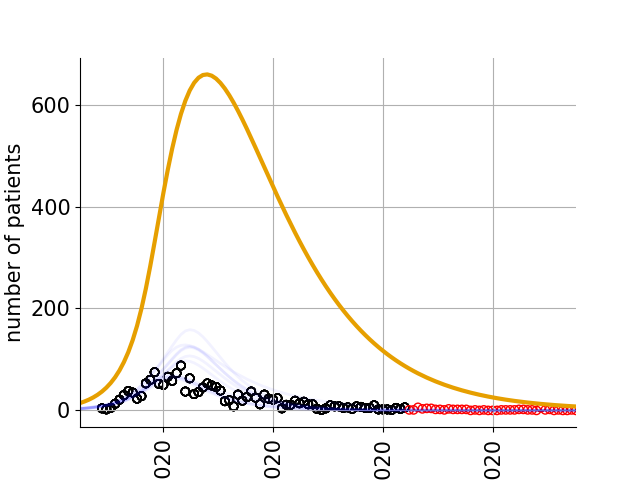

(18331.0, 18444.0)

In [22]:
states = [['H_in']]
end_date = '2020-07-01'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(10):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['policy_time'] = samples_dict['warmup']
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict['warmup'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict['warmup'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', '2020-07-01')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

# Step-by-step calibration per month

## Simulation until 1 July

In [23]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [25]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
model.parameters['policy_time'] = samples_dict_wave1['policy_time']

KeyError: 'policy_time'

In [26]:
out_july = model.sim(time='2020-07-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_july.isel(time=-1).mean(dim="draws")
initial_states_july1 = {key:states[key].values for key in initial_states.keys()}

<IPython.core.display.Javascript object>


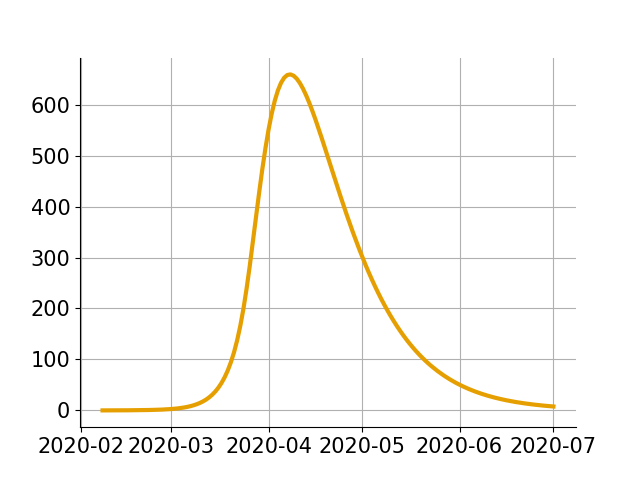

In [32]:
plt.figure()
plt.plot(out_july['time'],out_july['H_tot'].mean(dim="draws").sum(dim="Nc"))

In [34]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_july1.npy', initial_states_july1)

## Calibration month July

In [35]:
initial_states_july1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_july1.npy', allow_pickle=True).item()

In [36]:
# Second wave
start_date = '2020-07-01'
end_beta = '2020-08-01'

In [37]:
len(Luik_ts.loc[start_date:end_beta])

32

In [38]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_july = models.COVID19_SEIRD(initial_states_july1, params)

In [39]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_July'

In [40]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [41]:
samples_dict = full_calibration_wave2(model_july, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=100,discard=50)

100%|██████████| 100/100 [00:05<00:00, 17.84it/s]


Calibrating beta. Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!


In [42]:
samples_dict.keys()

dict_keys(['warmup', 'beta', 'calibration_data', 'start_date', 'end_beta', 'steps_mcmc', 'discard', 'R0', 'R0_stratified_dict'])

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(200):
    idx,model_july.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_july.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

## Simulation until 1 August

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_July_2020-10-30.json', 'r') as fp:
    samples_dict_july = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_aug = model_july.sim(time='2020-08-01', excess_time=0,start_date='2020-07-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_july)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', initial_states_aug1)

## Calibration month August

In [ ]:
initial_states_aug1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug1.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-09-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_aug = models.COVID19_SEIRD(initial_states_aug1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Aug'

In [ ]:
beta_init = np.mean(samples_dict_july['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
mu_beta, std_beta = norm.fit(samples_dict_july['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on july!
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
## Deze herrunnen!
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_aug.parameters['beta'] = random.choice(list(enumerate(samples_dict_aug['beta'])))
    y_model = model_aug.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

## Simulation until 1 September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_Aug_2020-10-30.json', 'r') as fp:
    samples_dict_aug = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
# model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
out_sept = model_aug.sim(time='2020-09-01', excess_time=0,start_date='2020-08-01',
                   N=100, draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_aug)
states = out_sept.isel(time=-1).mean(dim="draws")
initial_states_sept1 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', initial_states_sept1)

In [ ]:
initial_states_sept1

## Calibration month September

In [33]:
initial_states_sept1 = np.load('../data/interim/prediction_provinces/Luik_initial_states_sept1.npy', allow_pickle=True).item()

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/prediction_provinces/Luik_initial_states_sept1.npy'

In [ ]:
# Second wave
start_date = '2020-09-01'
end_beta = '2020-10-01'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_sept = models.COVID19_SEIRD(initial_states_sept1, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_Sept'

In [ ]:
beta_init = 0.03
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
# mu_beta, std_beta = norm.fit(samples_dict_aug['beta'])
# mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['sigma_data']) # should be on aug!
# beta_norm_params = (mu_beta, std_beta)
# sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None, None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_sept.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_sept.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Step-by-step per policy

# Calibration on entire period

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
initial_states_aug = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-08-01'
end_beta = '2020-10-25'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
#model_sept = models.COVID19_SEIRD(initial_states_sept, params)
model_aug = models.COVID19_SEIRD(initial_states_aug, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave2_from_aug_NVD'


In [ ]:
mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
samples_dict = full_calibration_wave2(model_aug, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, beta_norm_params,sigma_data_norm_params,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=500)

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave2_from_aug_NVD_2020-10-30.json', 'r') as fp:
    samples_dict = json.load(fp)


In [ ]:
pd.Series(samples_dict['beta']).describe()

In [ ]:
states = [['H_in']]
end_date = '2021-01-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(20):
    idx,model_aug.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model_aug.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-08-01', '2021-01-01')
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
fig.savefig(fig_path+spatial_unit+'.pdf',
            bbox_inches='tight', dpi=600)

# Calibration on increasing line

## Simulation until 28 September

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
def policies_until_september(t,param,start_date,policy_time,policy1,policy2,policy3,policy4,policy5,
                               policy6,policy7,policy8,policy9,policy10,l,tau,prevention):

    tau_days = pd.to_timedelta(tau, unit='D')
    l_days = pd.to_timedelta(l, unit='D')
    t1 = pd.to_datetime('2020-05-04') # reopening industry
    t2 = pd.to_datetime('2020-05-06') # merging of two bubbels
    t3 = pd.to_datetime('2020-05-11') # reopening of businesses
    t4 = pd.to_datetime('2020-05-18') # partial reopening schools
    t5 = pd.to_datetime('2020-06-04') # reopening schools, bars, restaurants
    t6 = pd.to_datetime('2020-07-01') # school holidays, gatherings 15 people, cultural event
    t7 = pd.to_datetime('2020-07-31') # ?
    t8 = pd.to_datetime('2020-07-31') # opening schools
    
    if t <= start_date + tau_days:
        return policy1
    elif start_date + tau_days < t <= start_date + tau_days + l_days:
        return ramp_fun(policy1, policy2, t, tau_days, l, start_date)
    elif start_date + tau_days + l_days < t <= t1: 
        return prevention*policy2
    elif t1 < t <= t2:
        return prevention*policy3
    elif t2 < t <= t3:
        return prevention*policy4
    elif t3 < t <= t4:
        return prevention*policy5
    elif t4 < t <= t5:
        return prevention*policy6
    elif t5 < t <= t6:
        return prevention*policy7
    elif t6 < t <= t7:
        return prevention*policy8
    elif t7 < t <= t8:
        return prevention*policy9
    elif t8 < t:
        return prevention*policy10

In [ ]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.25)*Nc_transport + (1-0.05)*Nc_others + (1-0.30)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + (1-0.40)*Nc_leisure,
              'policy10': 1.0*Nc_home + (1-0.00)*Nc_work + (1-0.00)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
              'policy_time': samples_dict_wave1['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date':pd.to_datetime('2020-03-15')})

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': policies_until_september})

In [ ]:
states = [['H_in']]
end_date = '2020-09-28'
data=[timeseries[start_date:end_ramp].values]

fig,ax=plt.subplots()
for i in range(10):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict_wave1['l'])))
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]
    model.parameters['policy_time'] = samples_dict_wave1['lag_time']
    model.parameters['prevention'] = samples_dict_wave1['prevention'][idx]
    y_model = model.sim(time=end_date, excess_time=samples_dict_wave1['lag_time'], start_date=start_date)
    ax = plot_fit(y_model,data,start_date,samples_dict_wave1['lag_time'],states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim('2020-03-10', end_date)
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)

In [ ]:
out_sept28 = model.sim(time='2020-09-28', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_sept28.isel(time=-1).mean(dim="draws")
initial_states_sept28 = {key:states[key].values for key in initial_states.keys()}

In [ ]:
np.save('../data/interim/prediction_provinces/Luik_initial_states_sept28.npy', initial_states_sept28)

## Calibration 28 Sept - 25 Oct

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
initial_states_sept28 = np.load('../data/interim/prediction_provinces/Luik_initial_states_sept28.npy', allow_pickle=True).item()

In [ ]:
# Second wave
start_date = '2020-09-28'
end_beta = '2020-10-25'

In [ ]:
len(Luik_ts.loc[start_date:end_beta])

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
model = models.COVID19_SEIRD(initial_states_sept28, params)

In [ ]:
# function parameters 
timeseries = Luik_ts['NEW_IN']
spatial_unit = 'Luik_wave2_from_Sept28'


In [ ]:
mu_beta, std_beta = norm.fit(samples_dict_wave1['beta'])
mu_sigma_data, std_sigma_data = norm.fit(samples_dict_wave1['beta'])
beta_norm_params = (mu_beta, std_beta)
sigma_data_norm_params = (mu_sigma_data, std_sigma_data)

In [ ]:
beta_init = np.mean(samples_dict_wave1['beta'])
sigma_data_init = np.mean(samples_dict_wave1['sigma_data'])

In [ ]:
samples_dict = full_calibration_wave2(model, timeseries, spatial_unit, start_date, end_beta, 
                                      beta_init, sigma_data_init, None,None,
                                      fig_path=fig_path, samples_path=samples_path,
                                      initN=initN, Nc_total=Nc_total,steps_mcmc=1000)

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
pd.Series(samples_dict['beta']).hist(ax=ax)

In [ ]:
states = [['H_in']]
end_date = '2020-11-01' #end_beta
data=[timeseries[start_date:end_beta].values]

fig,ax=plt.subplots(figsize=(8,8))
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    y_model = model.sim(time=end_date, excess_time=0, start_date=start_date)
    ax = plot_fit(y_model,data,start_date,lag_time=0,states=states,end_date=end_date,
                  with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 0)
#data_after_calib = timeseries[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
#plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
ax.set_xlim(start_date, end_date)
ax.set_ylabel('daily hospitalizations')
# fig.savefig(fig_path+spatial_unit+'.pdf',
#             bbox_inches='tight', dpi=600)